In [1]:
import os
import pickle
import numpy as np
import re

## Load training set documents

In [2]:
results_dir = "../results"
pickle_file = "stanza_proc_train.pkl"

in_path = os.path.join(results_dir, pickle_file)

with open(in_path, 'rb') as infile:
    train_set = pickle.load(infile)

/home/fab/.anaconda3/envs/txa_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
list(train_set[0].keys())

['id', 'raw_text', 'hs', 'stereotype', 'proc_text']

## Analyze Style

In [4]:
def is_nominal(sentence):
    """A sentence is nominal """
    root = sentence.root
    if root.upos == "VERB":
        if not root.feats:
            return False
        elif 'VerbForm=Fin' not in root.feats:
            return 'aux' not in sentence.root_deps
        else:
            return False
    else:
        return 'cop' not in sentence.root_deps

In [5]:
from stanza.models.common.doc import Sentence, Document
Sentence.add_property('n_tokens', default=0, getter=lambda self: len(self.tokens))
Sentence.add_property('n_words', default=0, getter=lambda self: len(self.words))
Sentence.add_property('lemmas', default=set(), getter=lambda self: set([word.lemma for word in self.words]))
Sentence.add_property('forms', default=set(), getter=lambda self: set([word.text.lower() for word in self.words]))
Document.add_property('n_sentences', default=0, getter=lambda self: len(self.sentences))
Document.add_property('avg_sent_length', default=0, getter=lambda self: np.mean([sent.n_tokens for sent in self.sentences]))
Document.add_property('avg_word_length', default=0, getter=lambda self: np.mean([len(token.text)
                                                                                 for sent in self.sentences for token in sent.tokens
                                                                               if token.words[0].upos != 'PUNCT']))
Document.add_property('lemmas', default=set(), getter=lambda self: {lemma
                                                                for sent in self.sentences
                                                                for lemma in sent.lemmas})
Document.add_property('forms', default=set(), getter=lambda self: {form
                                                                   for sent in self.sentences
                                                                   for form in sent.forms})
Document.add_property('ttr_lemma', default=0, getter=lambda self: len(self.lemmas) / self.num_words)
Document.add_property('ttr_form', default=0, getter=lambda self: len(self.forms) / self.num_words)

Sentence.add_property('root', default=dict(), getter=lambda self: [word
                                                                   for word in self.words
                                                                   if word.deprel == 'root'][0])
Sentence.add_property('root_deps', default=[], getter=lambda self: [deprel
                                                                    for head, deprel, _ in self.dependencies
                                                                    if head == self.root])
Sentence.add_property('is_nominal', default=False, getter=lambda self: is_nominal(self))
Document.add_property('n_nominal_sents', default=0, getter=lambda self: sum([sent.is_nominal
                                                                             for sent in self.sentences]))
Document.add_property('n_uppercase_words', default=0, getter=lambda self: sum([token.text.isupper()
                                                                            for token
                                                                            in self.iter_tokens()
                                                                            if len(token.text) > 1]))

In [6]:
HASHTAG_RE = re.compile(r'#([\w]+)')
UPOS_CONTENT = ['NOUN', 'PROPN', 'ADJ', 'ADV', 'VERB']
UPOS_NON_CONTENT = ['INTJ', 'ADP', 'AUX', 'CCONJ', 'DET', 'NUM',
                    'PART', 'PRON', 'SCONJ', 'PUNCT', 'SYM', 'X']

In [7]:
class StyleAnalyzer:
    def __init__(self, document: dict) -> None:
        self.id = document.get('id')
        self.raw_text = document.get('raw_text')
        self.hs = document.get('hs')
        self.stereotype = document.get('stereotype')
        self.proc_text = document.get('proc_text')
        self.style_feats = dict()

        self.analyze()

    def get_num_tokens(self):
        return self.proc_text.num_tokens

    def get_num_words(self):
        return self.proc_text.num_words

    def get_num_sentences(self):
        return self.proc_text.n_sentences

    def get_avg_sent_length(self):
        return self.proc_text.avg_sent_length

    def get_avg_word_length(self):
        return self.proc_text.avg_word_length

    def get_num_uppercase_words(self):
        """Number of words at least 2 characters long that are all in uppercase"""
        return self.proc_text.n_uppercase_words

    def get_num_mentions(self):
        return self.raw_text.count('@user')

    def get_num_urls(self):
        return self.raw_text.count('URL')

    def get_num_hashtags(self):
        return len(HASHTAG_RE.findall(self.raw_text))

    def get_ttr_lemma(self):
        """
        Type Token ratio computed with respect to lemmas.
        Ranges between 1 (high lexical variety) and 0 (low lexical variety).
        """
        return self.proc_text.ttr_lemma

    def get_ttr_form(self):
        """
        Type Token ratio computed with respect to forms
        Ranges between 1 (high lexical variety) and 0 (low lexical variety).
        """
        return self.proc_text.ttr_form

    def get_num_nominal_sents(self):
        """
        Number of nominal sentences.
        A nominal sentence is defined by the absence of a finite verb
        heading it's main clause.
        """
        return self.proc_text.n_nominal_sents

    def get_upos_dist(self):
        """Distribution of grammatical categories (upos)"""
        ud_pos = UPOS_CONTENT + UPOS_NON_CONTENT
        num_words = self.get_num_words()
        dist = {f"upos_dist_{pos_tag}": 0 for pos_tag in ud_pos}
        for sentence in self.proc_text.sentences:
            for word in sentence.words:
                dist[f"upos_dist_{word.upos}"] += 1
        return {feat_name: n / num_words for feat_name, n in dist.items()}

    def get_num_content_words(self):
        """Number of content words: NOUN PROPN ADV ADJ VERB"""
        return len([word
                    for sent in self.proc_text.sentences
                    for word in sent.words
                    if word.upos in UPOS_CONTENT])


    def analyze(self):
        # Raw text properties
        num_tokens = self.get_num_tokens()
        num_sentences = self.get_num_sentences()
        num_words = self.get_num_words()
        self.style_feats['num_tokens'] = num_tokens
        self.style_feats['num_sentences'] = num_sentences
        # Sentence and word length are proxies of syntactic complexity
        self.style_feats['avg_sent_length'] = self.get_avg_sent_length()
        self.style_feats['avg_word_length'] = self.get_avg_word_length()

        # Social media language properties
        self.style_feats['uppercase_words_dist'] = self.get_num_uppercase_words() / num_tokens
        self.style_feats['num_mentions'] = self.get_num_mentions()
        self.style_feats['num_hashtags'] = self.get_num_hashtags()
        self.style_feats['num_urls'] = self.get_num_urls()

        # Lexical variety
        self.style_feats['ttr_lemma'] = self.get_ttr_lemma()
        self.style_feats['ttr_form'] = self.get_ttr_form()

        # Morphosyntactic information
        self.style_feats.update(self.get_upos_dist())
        self.style_feats['lexical_density'] = self.get_num_content_words() / num_words

        # Syntactic features
        self.style_feats['nominal_sents_dist'] = self.get_num_nominal_sents() / num_sentences

    def to_dict(self):
        doc =  dict(
            id=self.id,
            hs=self.hs,
            stereotype=self.stereotype
        )
        doc.update(self.style_feats)
        return doc


In [8]:
doc = StyleAnalyzer(train_set[4])
print(doc.raw_text)
doc.to_dict()

Il divertimento del giorno? Trovare i patrioti italiani che inneggiano contro i rom facendo la spesa alla #Lidl (multinazionale tedesca). 


{'id': '949',
 'hs': '0',
 'stereotype': '0',
 'num_tokens': 24,
 'num_sentences': 2,
 'avg_sent_length': 12.0,
 'avg_word_length': 5.65,
 'uppercase_words_dist': 0.0,
 'num_mentions': 0,
 'num_hashtags': 1,
 'num_urls': 0,
 'ttr_lemma': 0.8076923076923077,
 'ttr_form': 0.8846153846153846,
 'upos_dist_NOUN': 0.23076923076923078,
 'upos_dist_PROPN': 0.038461538461538464,
 'upos_dist_ADJ': 0.07692307692307693,
 'upos_dist_ADV': 0.0,
 'upos_dist_VERB': 0.11538461538461539,
 'upos_dist_INTJ': 0.0,
 'upos_dist_ADP': 0.11538461538461539,
 'upos_dist_AUX': 0.0,
 'upos_dist_CCONJ': 0.0,
 'upos_dist_DET': 0.23076923076923078,
 'upos_dist_NUM': 0.0,
 'upos_dist_PART': 0.0,
 'upos_dist_PRON': 0.038461538461538464,
 'upos_dist_SCONJ': 0.0,
 'upos_dist_PUNCT': 0.15384615384615385,
 'upos_dist_SYM': 0.0,
 'upos_dist_X': 0.0,
 'lexical_density': 0.46153846153846156,
 'nominal_sents_dist': 1.0}

In [9]:
analyzed_docs = [StyleAnalyzer(doc) for doc in train_set]

In [10]:
import pandas as pd

In [11]:
train_df = pd.DataFrame.from_records([doc.to_dict() for doc in analyzed_docs], index='id')

In [12]:
train_df.head()

,hs,stereotype,num_tokens,num_sentences,avg_sent_length,avg_word_length,uppercase_words_dist,num_mentions,num_hashtags,num_urls,...,upos_dist_DET,upos_dist_NUM,upos_dist_PART,upos_dist_PRON,upos_dist_SCONJ,upos_dist_PUNCT,upos_dist_SYM,upos_dist_X,lexical_density,nominal_sents_dist
id,,,,,,,,,,,,,,,,,,,,,
2066,0,0,20,1,20.0,5.166667,0.0,0,0,1,...,0.095238,0.0,0.0,0.142857,0.047619,0.095238,0.0,0.0,0.380952,0.0
2045,0,0,15,1,15.0,4.733333,0.0,2,3,0,...,0.066667,0.0,0.0,0.133333,0.066667,0.000000,0.0,0.0,0.466667,0.0
61,0,0,13,1,13.0,6.181818,0.0,0,1,1,...,0.000000,0.0,0.0,0.000000,0.000000,0.153846,0.0,0.0,0.692308,1.0
1259,0,0,21,1,21.0,4.789474,0.0,1,0,0,...,0.142857,0.0,0.0,0.095238,0.095238,0.095238,0.0,0.0,0.380952,1.0
949,0,0,24,2,12.0,5.650000,0.0,0,1,0,...,0.230769,0.0,0.0,0.038462,0.000000,0.153846,0.0,0.0,0.461538,1.0


## Classifier

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [14]:
train_X = train_df.drop(['hs', 'stereotype'], axis=1)
train_y = train_df['hs']

In [15]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LinearSVC(dual=False))
], verbose=True)

pipeline

Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', LinearSVC(dual=False))],
         verbose=True)

In [16]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [17]:

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
}

In [18]:
scores = cross_validate(pipeline, train_X, train_y, scoring=scoring, cv=splitter)
print("Mean macro-f1", np.mean(scores['test_f1_macro']).round(3))
print("Standard deviation macro-f1", np.std(scores['test_f1_macro']).round(3))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s
Mean macro-f1 0.651
Standard deviation macro-f1 0.01


We compare the scores obtained by the linear support vector machine with the performance obtained by a dummy classifier that always predicts the most frequent class (i.e. not hate speech).

In [19]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
baseline_scores = cross_validate(dummy_clf, train_X, train_y, scoring=scoring, cv=splitter, n_jobs=1)
print(baseline_scores.keys())

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro'])


In [20]:
import matplotlib.pyplot as plt

In [21]:
scores_df = pd.DataFrame(scores)
scores_df['model'] = 'actual model'
scores_df['iteration'] = list(range(1, 6))
baseline_scores_df = pd.DataFrame(baseline_scores)
baseline_scores_df['model'] = 'dummy classifier'
baseline_scores_df['iteration'] = list(range(1, 6))

scores_df = pd.concat([scores_df, baseline_scores_df]).drop(['fit_time', 'score_time'], axis=1)
scores_df_long = pd.melt(scores_df, id_vars=['model', 'iteration'], var_name='metric')

In [22]:
import seaborn as sns

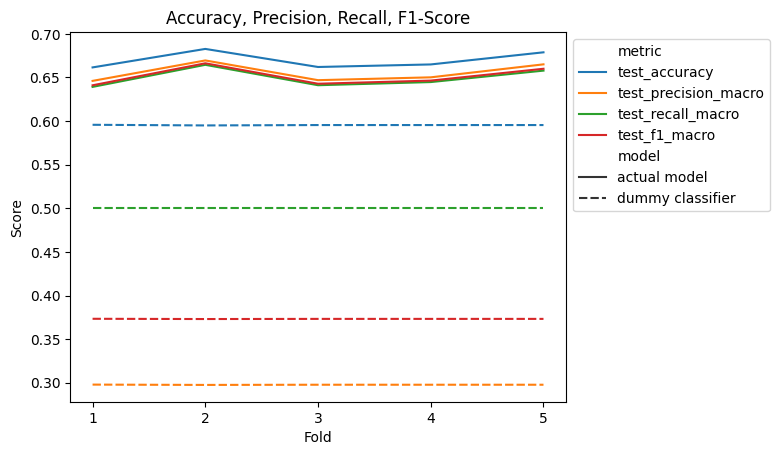

In [23]:
sns.lineplot(scores_df_long, x='iteration', y='value', hue='metric', style='model')
plt.xticks(list(range(1, 6)))
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Accuracy, Precision, Recall, F1-Score")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


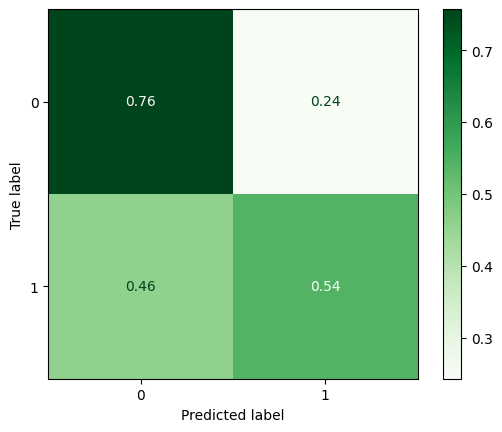

In [24]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = cross_val_predict(pipeline, train_X, train_y, cv=splitter)
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=train_y, cmap="Greens", normalize='true')
plt.show()

## Feature importance

In [25]:
pipeline.fit(train_X, train_y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', LinearSVC(dual=False))],
         verbose=True)

In [26]:
coefs = pipeline['clf'].coef_[0]
feat_names = pipeline[:-1].get_feature_names_out()

Most important features for positive class (hs)

In [27]:
feat_importance = pd.DataFrame(coefs, columns=("coef",), index=feat_names)
feat_importance.sort_values('coef', ascending=False).head()

,coef
num_sentences,1.610438
avg_word_length,1.235651
uppercase_words_dist,1.026306
avg_sent_length,0.660485
ttr_lemma,0.603611


Most important features for negative class (not hs)

In [28]:
feat_importance.sort_values('coef', ascending=True).head()

,coef
num_urls,-1.546653
ttr_form,-0.776432
upos_dist_PROPN,-0.726625
upos_dist_X,-0.681491
upos_dist_PUNCT,-0.458252
